## Module Imports

In [ ]:
import os

import pandas as pd
import numpy as np
import timeit

import matplotlib.pyplot as plt
import seaborn as sns

# Linear model for PCA
from sklearn.linear_model import LogisticRegression

# Estimation maximization
from sklearn.mixture import GaussianMixture

# Neural Network
from sklearn.neural_network import MLPClassifier

# Clustering Algo
from sklearn.cluster import KMeans

# Principal and indipendent component analysis
from sklearn.decomposition import FastICA, PCA

# Randomized projections
from sklearn.random_projection import GaussianRandomProjection,\
      SparseRandomProjection as RCA

# Manifolds
from sklearn.manifold import LocallyLinearEmbedding

# Mertrics
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import silhouette_score as s_score,\
      calinski_harabasz_score as ch_score,\
        homogeneity_completeness_v_measure as hcv_score, adjusted_rand_score as ar_score,\
        pairwise_distances
from sklearn.metrics import \
    balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.pipeline import make_pipeline, Pipeline

# pre-processing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import \
    LearningCurveDisplay, validation_curve, learning_curve, train_test_split, ShuffleSplit,\
          GridSearchCV, cross_validate



## Data Processing

In [ ]:
red_wine = os.path.join('data','wine', 'winequality-red.csv')
white_wine = os.path.join('data','wine', 'winequality-white.csv')
turbine = os.path.join('data','turbine','gt_2011.csv')
mushrooms = os.path.join('data','mushroom','secondary_data.csv')

# encoders to use
scale = StandardScaler()
s_split = ShuffleSplit()
ohe = OneHotEncoder(sparse_output=False)

## SHROOM DATA

In [ ]:
transformer = make_column_transformer(
    (
        ohe, 
        [
        'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment','gill-spacing', 'gill-color', 
       'stem-root', 'stem-surface', 'stem-color','veil-type', 'veil-color',
        'has-ring', 'ring-type', 'spore-print-color','habitat', 'season'
        ]
        ),
    remainder='passthrough'
    )

# pre-process shroom data

shroom_df = pd.read_csv(mushrooms,sep=';').sample(frac=1).reset_index(drop=True)
x = shroom_df.iloc[:,1:].copy()
x_shroom = pd.DataFrame(transformer.fit_transform(x), 
                columns=transformer.get_feature_names_out())
y = shroom_df.iloc[:,0].copy()
y_shroom = (y == 'p')


# reduce the number of training examples
x_shroom = x_shroom[:7000]
y_shroom =  y_shroom[:7000]

# Scale numerical attributes to be b/w 1 and -1
lst_of_num_cols = [
    'remainder__cap-diameter', 'remainder__stem-height', 'remainder__stem-width'
    ]
x_shroom[lst_of_num_cols] = scale.fit_transform(x_shroom[lst_of_num_cols])

## WINE DATA

In [ ]:
white_df = pd.read_csv(white_wine, sep=';')
red_df = pd.read_csv(red_wine, sep=';')
white_df['type'] = 0
red_df['type'] = 1
wine_df = pd.concat([white_df,red_df])
wine_df = wine_df.sample(frac=1).reset_index(drop=True)

# set x and y values
# remove 'quality' and 'type' column from x array
x_wine = wine_df.iloc[:,:-2].copy()
# scale x vals
x_wine.values[:,:] = scale.fit_transform(x_wine)
# set y array equal to 'type' column 
y_wine = wine_df.iloc[:,-1].copy()

## Shroom and Wine Train/Test Split

In [ ]:
x_shroom_train, x_shroom_test, y_shroom_train, y_shroom_test =\
      train_test_split(x_shroom, y_shroom, test_size=0.2)

x_wine_train, x_wine_test, y_wine_train, y_wine_test =\
      train_test_split(x_wine, y_wine, test_size=0.2)


## Helper Functions

In [167]:
def generate_validation_curve(model, param_grid, x_data, y_data,
                          x_range, param_name, model_name, axs,\
                          plot_train=True, plot_test=True):
    
    train_score, test_score = validation_curve(model, x_data, y_data, 
                                 fit_params=param_grid, scoring='f1_score')
    
    train_mean = train_score.mean(1)
    train_sd = train_score.std(1)
    test_mean = test_score.mean(1)
    test_sd = test_score.std(1)
    axs = axs
    x = x_range
    if plot_train:
        line, = axs.plot(x,train_mean, 'o-')
        axs.fill_between(x,train_mean + train_sd, train_mean - train_sd,alpha=0.3)
    if plot_test:
        axs.plot(x,test_mean,'o-')
        axs.fill_between(x, test_mean + test_sd, test_mean - test_sd,alpha=0.3)
    axs.set_title(f'{model_name} validation curve', fontsize = 15)
    axs.set_xlabel(f'{param_name}', fontsize = 15)
    axs.set_ylabel(f'f1 score', fontsize = 15)
    axs.legend()
    axs.tick_params(axis='both', which='major', labelsize=15)
    axs.tick_params(axis='both', which='minor', labelsize=15)

    return line

In [168]:
def generate_learning_curve(model, param_grid, x_data, y_data,
                          x_range, param_name, model_name, axs,\
                          plot_train=True, plot_test=True):
    
    train_sizes, train_scores, test_scores, fit_times, score_times =\
          learning_curve(model, x_data, y_data,)

    train_mean = train_scores.mean(1)
    train_sd = train_scores.std(1)
    test_mean = test_scores.mean(1)
    test_sd = test_scores.std(1)
    fit_mean = fit_times.mean(1)
    fit_std = fit_times.std(1)
    score_mean = score_times.mean(1)
    score_std = score_times.std(1)

    return None

In [169]:
def plot_curve(x_data, y_data, axs=None, take_mean=False):

    if axs == None:
        _, axs = plt.subplots()

    if take_mean:
        y_mean = y_data.mean(1)
        y_std = y_data.std(1)
        axs.plot(x_data,y_mean,'o-')
        line = axs.fill_between(x_data, y_mean + y_std, y_mean - y_std,alpha=0.3)
    else:
        line = axs.plot(x_data, y_data)

    return line

In [170]:
def perform_kmeans(x_data, y_data, num_runs=5):
    import warnings
    from sklearn.exceptions import DataConversionWarning
    warnings.filterwarnings(action='ignore', category=DataConversionWarning)
    
    r_state = 123456
    num_clusters = np.arange(2,50)
    train_time_dict = {}
    s_score_dict = {}
    ch_score_dict = {}
    v_score_dict = {}
    ar_score_dict = {}

    for i in list(range(num_runs)):

        train_time_lst = []
        s_score_lst = []
        ch_score_lst = []
        v_score_lst = []
        ar_score_lst = []

        for num in num_clusters:

            st = timeit.default_timer()
            k_model = KMeans(n_init=10, n_clusters=num).fit(x_data)
            et = timeit.default_timer()
            k_model.fit(x_data, y_data)
            train_time_lst.append(et - st)

            h,c,v = hcv_score(y_data, k_model.labels_)
            v_score_lst.append(v)
            ar_score_lst.append(ar_score(y_data, k_model.labels_))

            ch_score_lst.append(
                ch_score(y_data.to_numpy().reshape(-1,1), k_model.labels_.reshape(-1,1))
                )
            
            s_score_lst.append(
                s_score(y_data.to_numpy().reshape(-1,1), k_model.labels_.reshape(-1,1))
                )
            
        
        train_time_dict[f'train_iter_{i}'] = train_time_lst
        s_score_dict[f's_score_iter_{i}'] = s_score_lst
        v_score_dict[f'v_score_iter_{i}'] = v_score_lst
        ch_score_dict[f'ch_score_iter_{i}'] = ch_score_lst
        ar_score_dict[f'ar_score_iter_{i}'] = ar_score_lst

    df_time = pd.DataFrame(train_time_dict)
    df_s_score = pd.DataFrame(s_score_dict)
    df_v_score = pd.DataFrame(v_score_dict)
    df_ch_score = pd.DataFrame(ch_score_dict)
    df_ar_score = pd.DataFrame(ar_score_dict)

    df_results = pd.DataFrame({
        'num_clusters': num_clusters,
        'mean_fit_time': df_time.mean(1),
        'std_fit_time': df_time.std(1),
        'mean_s_score': df_s_score.mean(1),
        'std_s_score': df_s_score.std(1),
        'mean_v_score': df_v_score.mean(1),
        'std_v_score': df_v_score.std(1),
        'mean_ch_score': df_ch_score.mean(1),
        'std_ch_score': df_ch_score.std(1),
        'mean_ar_score': df_ar_score.mean(1),
        'std_ar_score': df_ar_score.std(1)
        })

    return df_results

In [171]:
def perform_em(x_data):

    def gmm_bic_score(estimator, x_data):
        """Callable to pass to GridSearchCV that will use the BIC score."""
        # Make it negative since GridSearchCV expects a score to maximize
        return -estimator.bic(x_data)


    param_grid = {
        "n_components": np.arange(1,51, 1),
        "covariance_type": ["full"],
    }

    grid_search = GridSearchCV(
        GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
    )

    grid_search.fit(x_data)

    
    df = pd.DataFrame(grid_search.cv_results_)[
        ["param_n_components", "param_covariance_type", "mean_test_score","std_test_score",
          "mean_fit_time", "std_fit_time", "mean_score_time", "std_score_time"]
    ]
    
    df["mean_test_score"] = -df["mean_test_score"]

    df = df.rename(
        columns={
            "param_n_components": "n_components",
            "param_covariance_type": "covariance_type",
            "mean_test_score": "bic_score",
            "std_test_score": "std_bic_score",
        }
    )
    df = df.sort_values(by="bic_score")

    return df

In [172]:
def perform_pca(x_data):

    pca = PCA(whiten=True, svd_solver='full')
    pca.fit(x_data)
    cum_explained_variance = np.cumsum(pca.explained_variance_ratio_)
    
    return cum_explained_variance

In [194]:
def perform_ica(x_data):

    if x_data.shape[1] > 20:
        n_components = np.arange(2,x_data.shape[1]+1, 5)
    else:
        n_components = np.arange(2,x_data.shape[1]+1)
        
    average_kurtosis_lst = []
    std_kurtosis_lst = []

    for n in n_components:
        ica = FastICA(n_components=n)
        df_temp = pd.DataFrame(ica.fit_transform(x_data))
        df_temp = df_temp.kurtosis(axis=0)
        average_kurtosis_lst.append(df_temp.abs().mean())
        std_kurtosis_lst.append(df_temp.abs().std())

    df_result = pd.DataFrame({
        'num_components': n_components,
        'mean_kurtosis': average_kurtosis_lst,
        'std_kurtosis': std_kurtosis_lst
    })

    return df_result

In [174]:
def pdist_correllation(x_data_1,x_data_2):
    
    rmse = ((x_data_1- x_data_2.to_numpy()) ** 2).mean()
    
    return rmse

In [175]:
def perform_rca(x_data, num_runs=5):

    if x_data.shape[1] > 20:
        n_components = np.arange(2,x_data.shape[1]+1, 5)
    else:
        n_components = np.arange(2,x_data.shape[1]+1)
        
    average_recon_error_dict = {}

    for num in list(range(num_runs)):
        average_recon_error_lst = []

        for n in n_components:
            rca = RCA(n_components=n)
            average_recon_error_lst.\
                append(
                    pdist_correllation(
                        rca.inverse_transform(rca.fit_transform(x_data)), x_data
                        )
                    )
            
        average_recon_error_dict[f'r_error_{num}'] = average_recon_error_lst

    df_recon = pd.DataFrame(average_recon_error_dict)
    df_result = pd.DataFrame({
        'num_components': n_components,
        'mean_recon_error': df_recon.mean(1),
        'std_recon_error': df_recon.std(1)
    })

    return df_result

In [176]:
def perform_manifold(x_data, num_runs=5):
    if x_data.shape[1] > 20:
        n_components = np.arange(2,x_data.shape[1]+1, 5)
        es='dense'
    else:
        n_components = np.arange(2,x_data.shape[1]+1)
        es='auto'
    
    average_recon_error_dict = {}
    
    for num in list(range(num_runs)):
        average_recon_error_lst = []
        for n in n_components:
            lle = LocallyLinearEmbedding(n_components=n, eigen_solver=es)
            lle.fit_transform(x_data)
            average_recon_error_lst.append(lle.reconstruction_error_)
            
        average_recon_error_dict[f'r_error_{num}'] = average_recon_error_lst

    df_recon = pd.DataFrame(average_recon_error_dict)
    df_result = pd.DataFrame({
        'num_components': n_components,
        'mean_recon_error': df_recon.mean(1),
        'std_recon_error': df_recon.std(1)
    })

    return df_result

In [177]:
def perform_nn(x_data, y_data):

    # Neural Network hyper tuning
    # defining parameter range 
    param_grid = {
    'learning_rate': ["constant"],
    'hidden_layer_sizes': [(10,),(50,),(100,),(200,)],
    'learning_rate_init': np.linspace(0.01, 1, 5),
    'activation': ['relu'],
    'solver': ['sgd']
    }

    grid = GridSearchCV(MLPClassifier(), param_grid, scoring='f1',\
                        refit = True, verbose = 3,n_jobs=-1) 
    
    # fitting the model for grid search 
    grid.fit(x_data, y_data) 
    
    return grid.best_estimator_

## Model Instantiation

In [ ]:
r_state = 123456

# Expectation Maximization: Clustering
gmx = GaussianMixture(random_state=r_state)

# Kmeans: Clustering
km = KMeans(random_state=r_state, n_init=10, n_clusters=2)

# Manifold: Dimension Reduction
lle = LocallyLinearEmbedding(random_state=r_state)

# Look at distribution of Eigenvalues or explained variance
# Dimension Reduction
pca = PCA(random_state=r_state)

# Use kurtosisfor performance eval
# Dimension Reduction
ica = FastICA(random_state=r_state)

# Use reconstruction error
grp = GaussianRandomProjection(compute_inverse_components=True,random_state=r_state)

# Neural network, use f1 score
# Wine Params: {'activation': 'relu', 'hidden_layer_sizes': (100,), 
#               'learning_rate': 'constant', 'learning_rate_init': 0.89, 'solver': 'sgd'}
# Shroom Params: {'activation': 'relu', 'hidden_layer_sizes': (100,),
#                'learning_rate': 'constant', 'learning_rate_init': 0.01, 'solver': 'sgd'}
mlp = MLPClassifier(random_state=r_state)

In [ ]:
km.fit_transform(x_shroom)
fig, ax = plt.subplots(2,2, sharex=True, sharey=True)
ax = ax.flatten()
ax[0].scatter(x_shroom.iloc[:,-1], x_shroom.iloc[:,-2], c=km.labels_)
ax[1].scatter(x_shroom.iloc[:,-1], x_shroom.iloc[:,-2], c=y_shroom)
ax[2].scatter(x_shroom.iloc[:,-1], x_shroom.iloc[:,-3], c=km.labels_)
ax[3].scatter(x_shroom.iloc[:,-1], x_shroom.iloc[:,-3], c=y_shroom)
plt.show()

## Wine: Clustering

In [160]:
df_em = perform_em(x_wine)

In [161]:
df_em.head(3)

,n_components,covariance_type,bic_score,std_bic_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
4,5,full,28658.046041,212.460458,0.311266,0.079631,0.003943,0.005915
3,4,full,28799.650556,177.874255,0.170213,0.046105,0.004592,0.004241
5,6,full,29047.983379,410.775961,0.380125,0.067783,0.005725,0.007061


In [164]:
mask = df_em['bic_score'] == df_em['bic_score'].min()
df_em[mask]

,n_components,covariance_type,bic_score,std_bic_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
4,5,full,28658.046041,212.460458,0.311266,0.079631,0.003943,0.005915


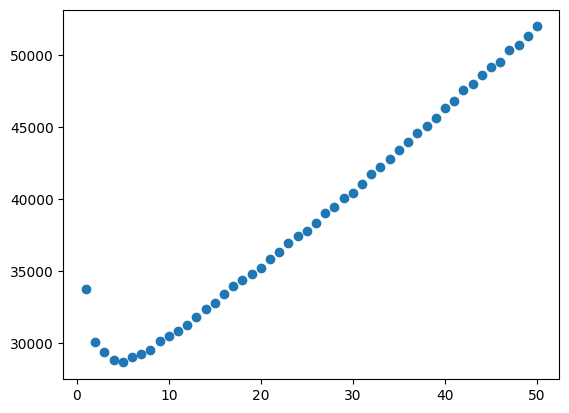

In [162]:
plt.scatter(df_em['n_components'],df_em['bic_score'])
plt.show()

In [197]:
df_ica = perform_ica(x_wine)
df_ica.head()

,num_components,mean_kurtosis,std_kurtosis
0,2,1.066630,1.319314
1,3,1.746521,2.088425
2,4,2.423712,1.996640
3,5,8.594149,16.191628
4,6,7.656628,14.648242


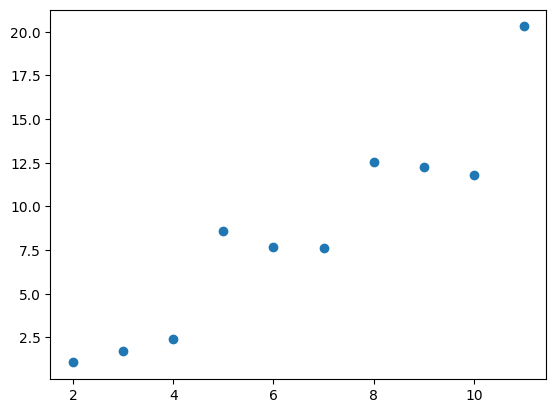

In [200]:
plt.scatter(df_ica['num_components'], df_ica['mean_kurtosis'])

In [199]:
df_man = perform_manifold(x_wine, num_runs=2)
df_man.head(3)

,num_components,mean_recon_error,std_recon_error
0,2,5.587618e-18,1.650934e-19
1,3,6.751816e-18,1.126470e-19
2,4,1.917754e-17,4.321820e-19


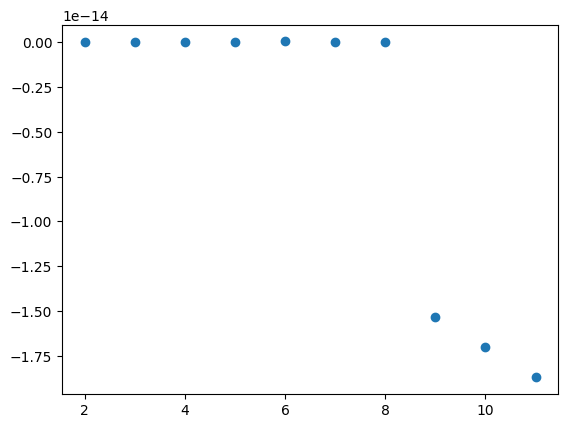

In [202]:
plt.scatter(df_man['num_components'],df_man['mean_recon_error'])
plt.show()

In [203]:
df_man_show = perform_manifold(x_shroom, num_runs=2)
df_man_show.head(3)
plt.scatter(df_man_show['num_components'],df_man_show['mean_recon_error'])
plt.show()

ValueError: Error in determining null-space with ARPACK. Error message: 'Factor is exactly singular'. Note that eigen_solver='arpack' can fail when the weight matrix is singular or otherwise ill-behaved. In that case, eigen_solver='dense' is recommended. See online documentation for more information.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# Define a Standard Scaler to normalize inputs
scaler = StandardScaler()

# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[("pca", pca), ("logistic", logistic)])

param_grid = {
    "pca__n_components": np.arange(1, (x_shroom.shape[1]+1)),
    "logistic__C": np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=2)
search.fit(x_shroom, y_shroom)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import datasets

# Plot the PCA spectrum
pca.fit(x_shroom)
cumsum = np.cumsum(pca.explained_variance_ratio_)
fig, ax0 = plt.subplots()
ax0.plot(cumsum, "+", linewidth=2)
ax0.set_ylabel("cumulative explained variance ratio")

ax0.axhline(
    0.95,
    linestyle=":",
    label="95% Variance",
)
ax0.axvline(
    60,
    linestyle=":",
    label="n-components",
)
ax0.legend(prop=dict(size=12))
plt.show()

In [ ]:
x_data=x_wine 
num_runs=2

if x_data.shape[1] > 10:
    
    n_components = np.arange(2,x_data.shape[1]+1)
else:
    n_components = np.arange(2,x_data.shape[1]+1, 5)
    
    
average_recon_error_dict = {}

for num in list(range(num_runs)):
    average_recon_error_lst = []

    for n in n_components:
        rca = RCA(n_components=n)
        average_recon_error_lst.\
            append(
                pdist_correllation(
                    rca.inverse_transform(rca.fit_transform(x_data)), x_data
                    )
                )
        
    average_recon_error_dict[f'r_error_{num}'] = average_recon_error_lst

df_recon = pd.DataFrame(average_recon_error_dict)
df_result = pd.DataFrame({
    'num_components': n_components,
    'mean_recon_error': df_recon.mean(1),
    'std_recon_error': df_recon.std(1)
})

In [ ]:
plt.plot(df_result['num_components'],df_result['mean_recon_error'])
plt.show()